<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Deep Learning From Scratch</h1>
<h2>Modular Network</h2>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import watermark

%load_ext watermark
%matplotlib inline

In [2]:
%watermark -i -n -v -m -g -iv

numpy      1.16.2
seaborn    0.9.0
watermark  1.8.1
pandas     0.24.2
matplotlib 3.1.0
Sun Dec 01 2019 2019-12-01T23:21:36-04:00

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.0.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : 1aa3ac8e019f5a80d5859a063dba4cefad42fbaf


In [3]:
plt.style.use('./d4sci.mplstyle')

# Load Dataset

In [4]:
X_train = np.load('input/X_train.npy')
X_test = np.load('input/X_test.npy')
y_train = np.load('input/y_train.npy')
y_test = np.load('input/y_test.npy')

Preprocessing

In [5]:
input_layer_size = X_train.shape[1]

X_train /= 255.
X_test /= 255.

## Initialize weights

We define the initializatino function as we'll have to call it more than once

In [6]:
def init_weights(L_in, L_out):
    epsilon = 0.12

    return 2*np.random.rand(L_out, L_in+1)*epsilon - epsilon

Set the layer sizes we'll be using

In [7]:
hidden_layer_size = 50
num_labels = 10

Initialize the weights. In this case we use a array of weight matrices so that we can easily add/remove layers

In [8]:
Thetas = []
Thetas.append(init_weights(input_layer_size, hidden_layer_size))
Thetas.append(init_weights(hidden_layer_size, num_labels))

## Utility functions

One-hot encoding to define the labels

In [9]:
def one_hot(K, pos):
    y0 = np.zeros(K)
    y0[pos] = 1

    return y0

Activation function base class. Here we must provide an interface to both the activation function and its derivative

In [10]:
class Activation(object):
    def f(z):
        pass

    def df(z):
        pass

The various activation functions simply extend the base class

In [11]:
class Linear(Activation):
    def f(z):
        return z

    def df(z):
        return np.ones(z.shape)

class ReLu(Activation):
    def f(z):
        return np.where(z > 0, z, 0)

    def df(z):
        return np.where(z > 0, 1, 0)

class Sigmoid(Activation):
    def f(z):
        return 1./(1+np.exp(-z))
    
    def df(z):
        h = Sigmoid.f(z)
        return h*(1-h)

class TanH(Activation):
    def f(z):
        return np.tanh(z)

    def df(z):
        return 1-np.power(np.tanh(z), 2.0)

## Forward Propagation and Prediction

The forward and predict functions are also generalized

In [12]:
def forward(Theta, X, active):
    N = X.shape[0]

    # Add the bias column
    X_ = np.concatenate((np.ones((N, 1)), X), 1)

    # Multiply by the weights
    z = np.dot(X_, Theta.T)

    # Apply the activation function
    a = active.f(z)

    return a

The predict function now takes the entire model as input and it must loop over the various layers

In [13]:
def predict(model, X):
    h = X.copy()

    for i in range(0, len(model), 2):
        theta = model[i]
        activation = model[i+1]

        h = forward(theta, h, activation)

    return np.argmax(h, 1)

The accuracy function is just the same as before

In [14]:
def accuracy(y_, y):
    return np.mean((y_ == y.flatten()))*100.

## Back propagation

In [15]:
def backprop(model, X, y):
    M = X.shape[0]

    Thetas=[0]
    Thetas.extend(model[0::2])
    activations = [0]
    activations.extend(model[1::2])

    layers = len(Thetas)

    K = Thetas[-1].shape[0]
    J = 0

    Deltas = [0]

    for i in range(1, layers):
        Deltas.append(np.zeros(Thetas[i].shape))

    deltas = [0]*(layers+1)

    for i in range(M):
        As = [0]
        Zs = [0, 0]
        Hs = [0, X[i]]

        # Forward propagation, saving intermediate results
        As.append(np.concatenate(([1], Hs[1])))  # Input layer

        for l in range(2, layers+1):
            Zs.append(np.dot(Thetas[l-1], As[l-1]))
            Hs.append(activations[l-1].f(Zs[l]))
            As.append(np.concatenate(([1], Hs[l])))

        y0 = one_hot(K, y[i])

        # Cross entropy
        J -= np.dot(y0.T, np.log(Hs[-1]))+np.dot((1-y0).T, np.log(1-Hs[-1]))

        deltas[layers] = Hs[layers]-y0

        # Calculate the weight deltas
        for l in range(layers-1, 1, -1):
            deltas[l] = np.dot(Thetas[l].T, deltas[l+1])[1:]*activations[l].df(Zs[l])

        Deltas[2] += np.outer(deltas[3], As[2])
        Deltas[1] += np.outer(deltas[2], As[1])

    J /= M

    grads = []

    grads.append(Deltas[1]/M)
    grads.append(Deltas[2]/M)

    return [J, grads]

## Model Definition

In [16]:
model = []

model.append(Thetas[0])
model.append(Sigmoid)
model.append(Thetas[1])
model.append(Sigmoid)

## Training procedure
The same basic idea as before

In [17]:
step = 0
tol = 1e-3
J_old = 1/tol
diff = 1

acc_train = []
acc_test = []
J_val = []
steps = []

while diff > tol:
    J_train, grads = backprop(model, X_train, y_train)

    diff = abs(J_old-J_train)
    J_old = J_train
    J_val.append(J_train)

    step += 1

    if step % 10 == 0:
        pred_train = predict(model, X_train)
        pred_test = predict(model, X_test)

        J_test, grads = backprop(model, X_test, y_test)

        acc_train.append(accuracy(pred_train, y_train))
        acc_test.append(accuracy(pred_test, y_test))
        steps.append(step)
        
        print(step, J_train, J_test, acc_train[-1], acc_test[-1])

    for i in range(len(Thetas)):
        Thetas[i] -= .5*grads[i]

10 3.1151794124172834 3.1284540761600312 42.54 37.7
20 2.8930812858260424 2.9245023338635803 57.42 52.7
30 2.5765997922138273 2.6310790222300082 62.8 58.699999999999996
40 2.2588077102548567 2.3318459886065654 67.75999999999999 63.5
50 2.0051323700810464 2.0891283681509045 72.24000000000001 68.30000000000001
60 1.8097577603263248 1.9000148128895225 75.68 71.8
70 1.6538674046564426 1.7479445203727637 78.36 74.4
80 1.5254851412895871 1.6220707937282561 80.62 76.0
90 1.4177850084709327 1.516218295726227 82.42 77.8
100 1.3263270795325142 1.426330741765939 83.84 79.3
110 1.2478535139169256 1.349344780549471 84.86 81.8
120 1.1798644429405565 1.2828370182092799 85.94000000000001 82.5
130 1.12043074815847 1.2248925006341562 86.68 84.0
140 1.068066397216133 1.1740112750037648 87.16000000000001 84.39999999999999
150 1.0216224348437368 1.129020954006512 87.58 85.0
160 0.9801994355021234 1.0889983585542797 88.03999999999999 85.7
170 0.9430794853485821 1.0532054608870782 88.42 86.2
180 0.9096765952

## Accuracy during training

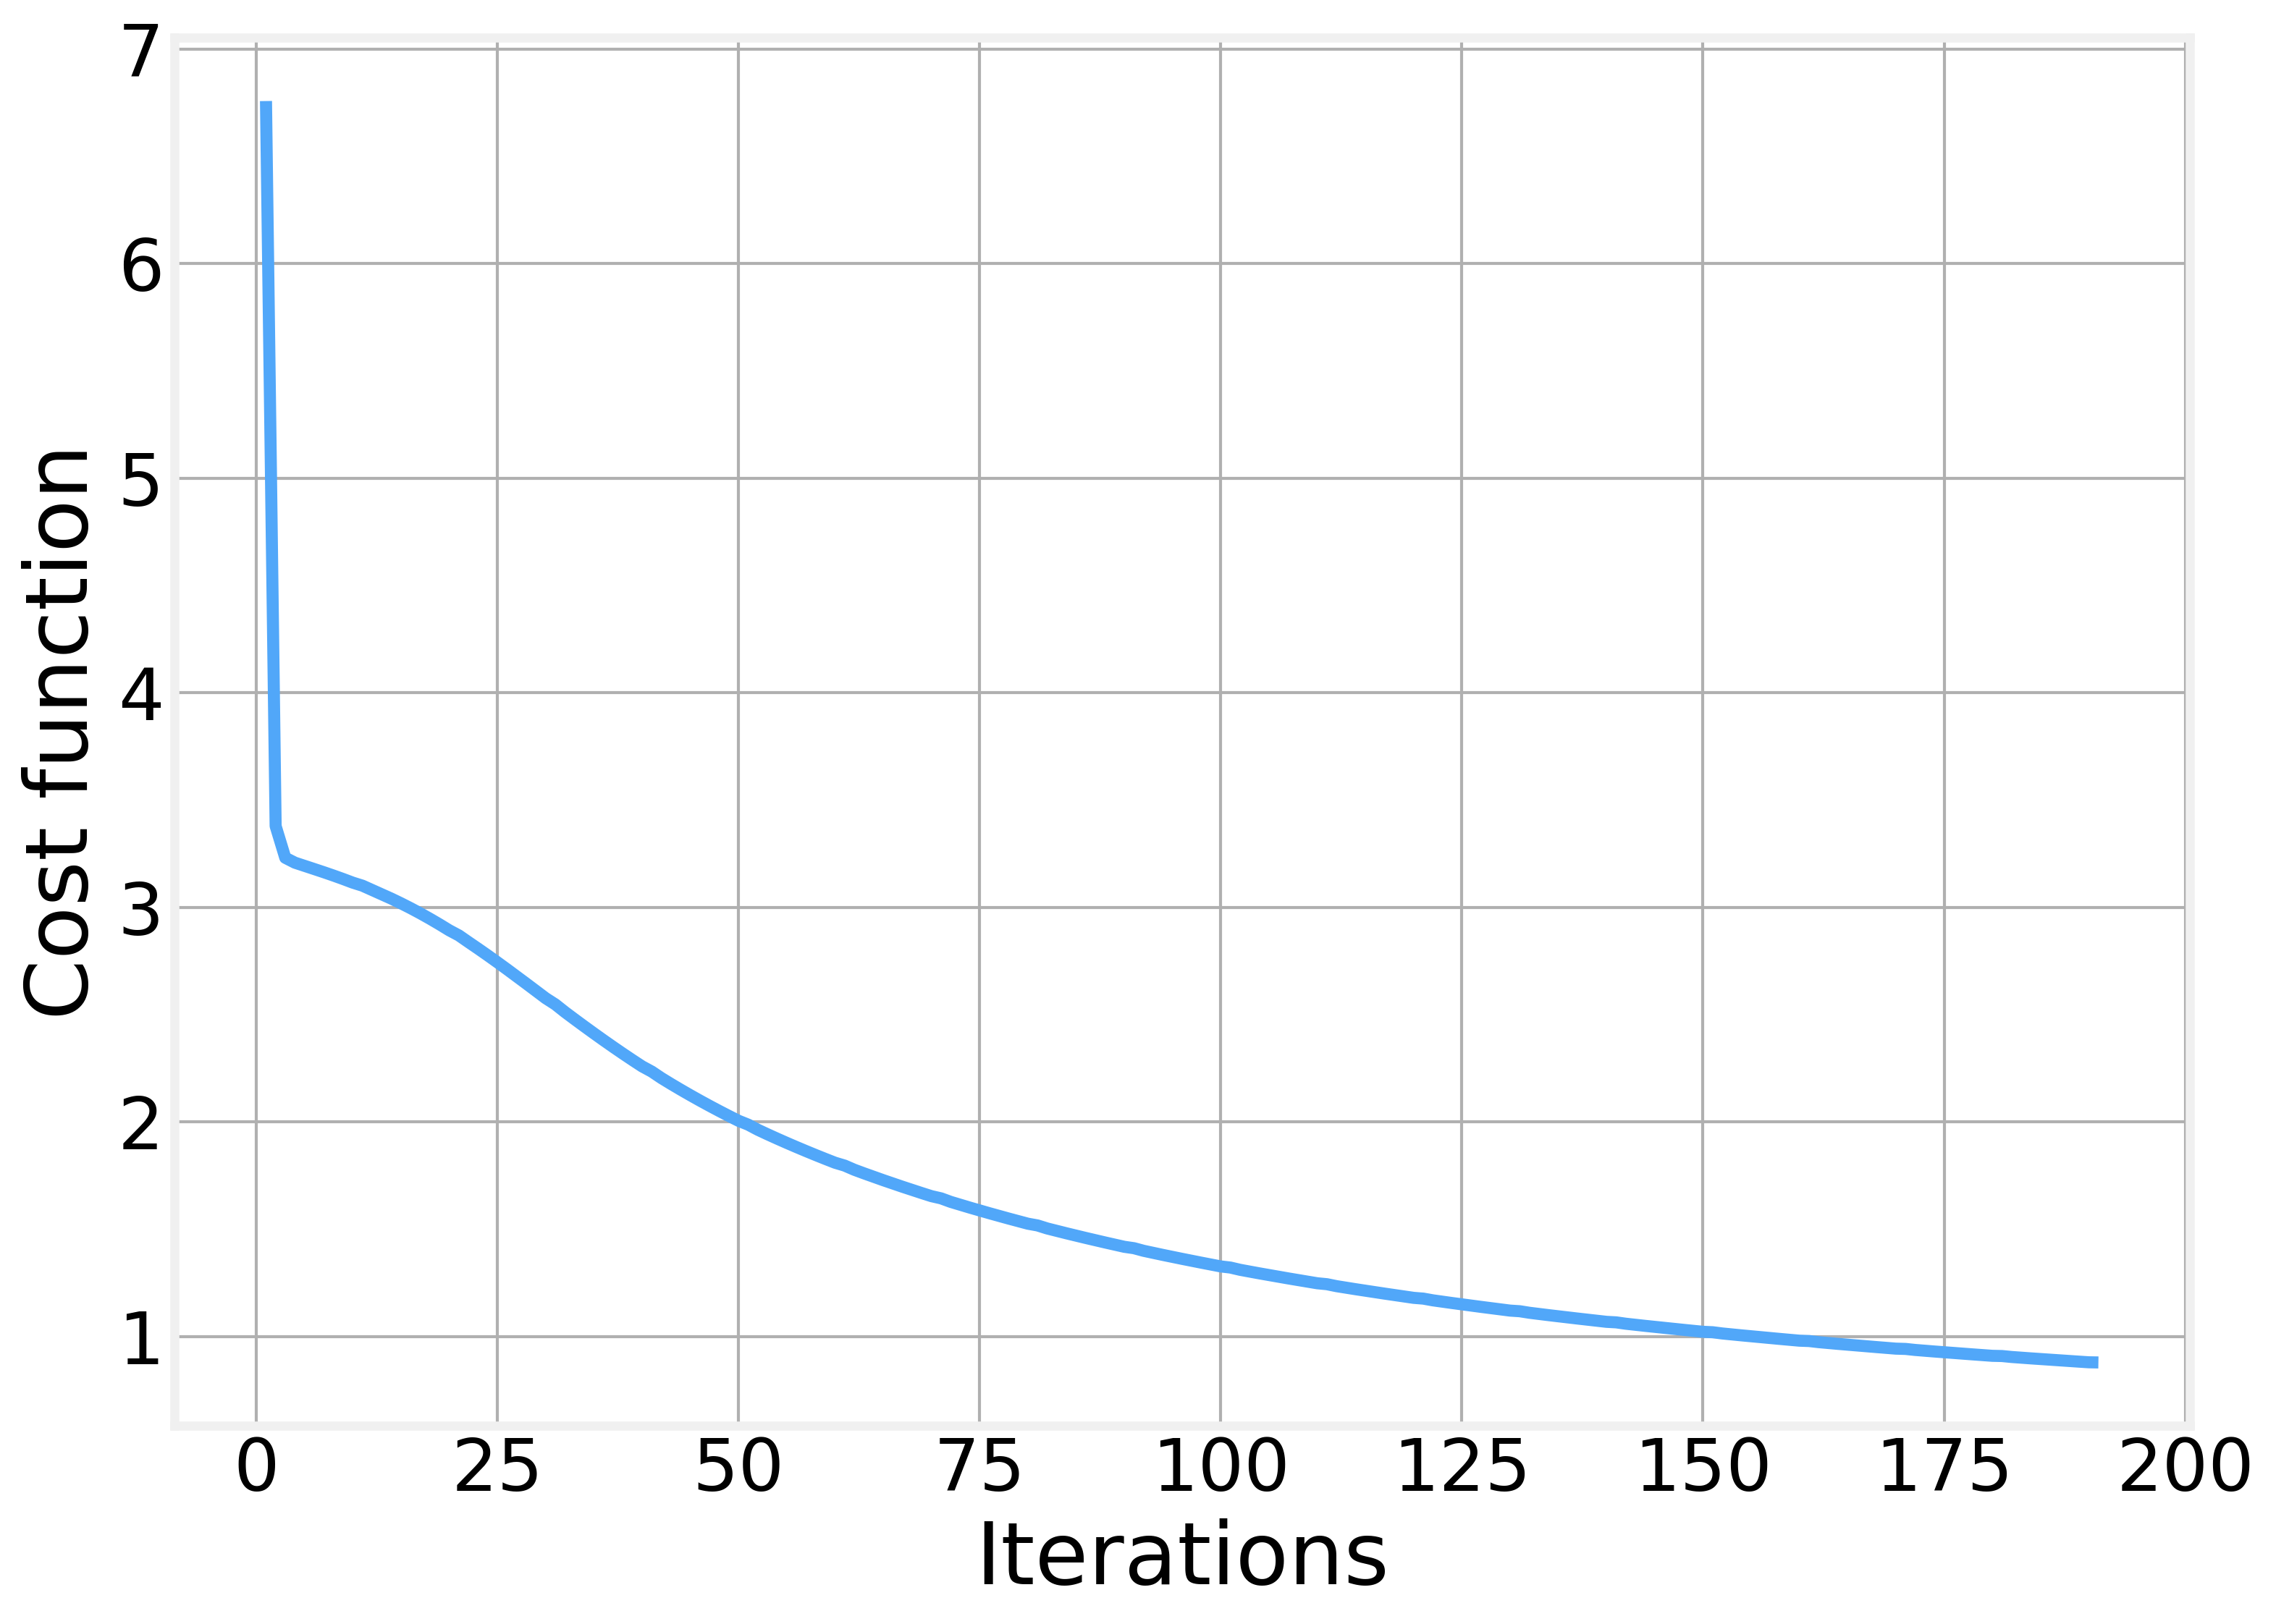

In [18]:
plt.plot(np.arange(1, len(J_val)+1), J_val)
plt.xlabel("Iterations")
plt.ylabel("Cost function")
plt.gcf().set_size_inches(11, 8)

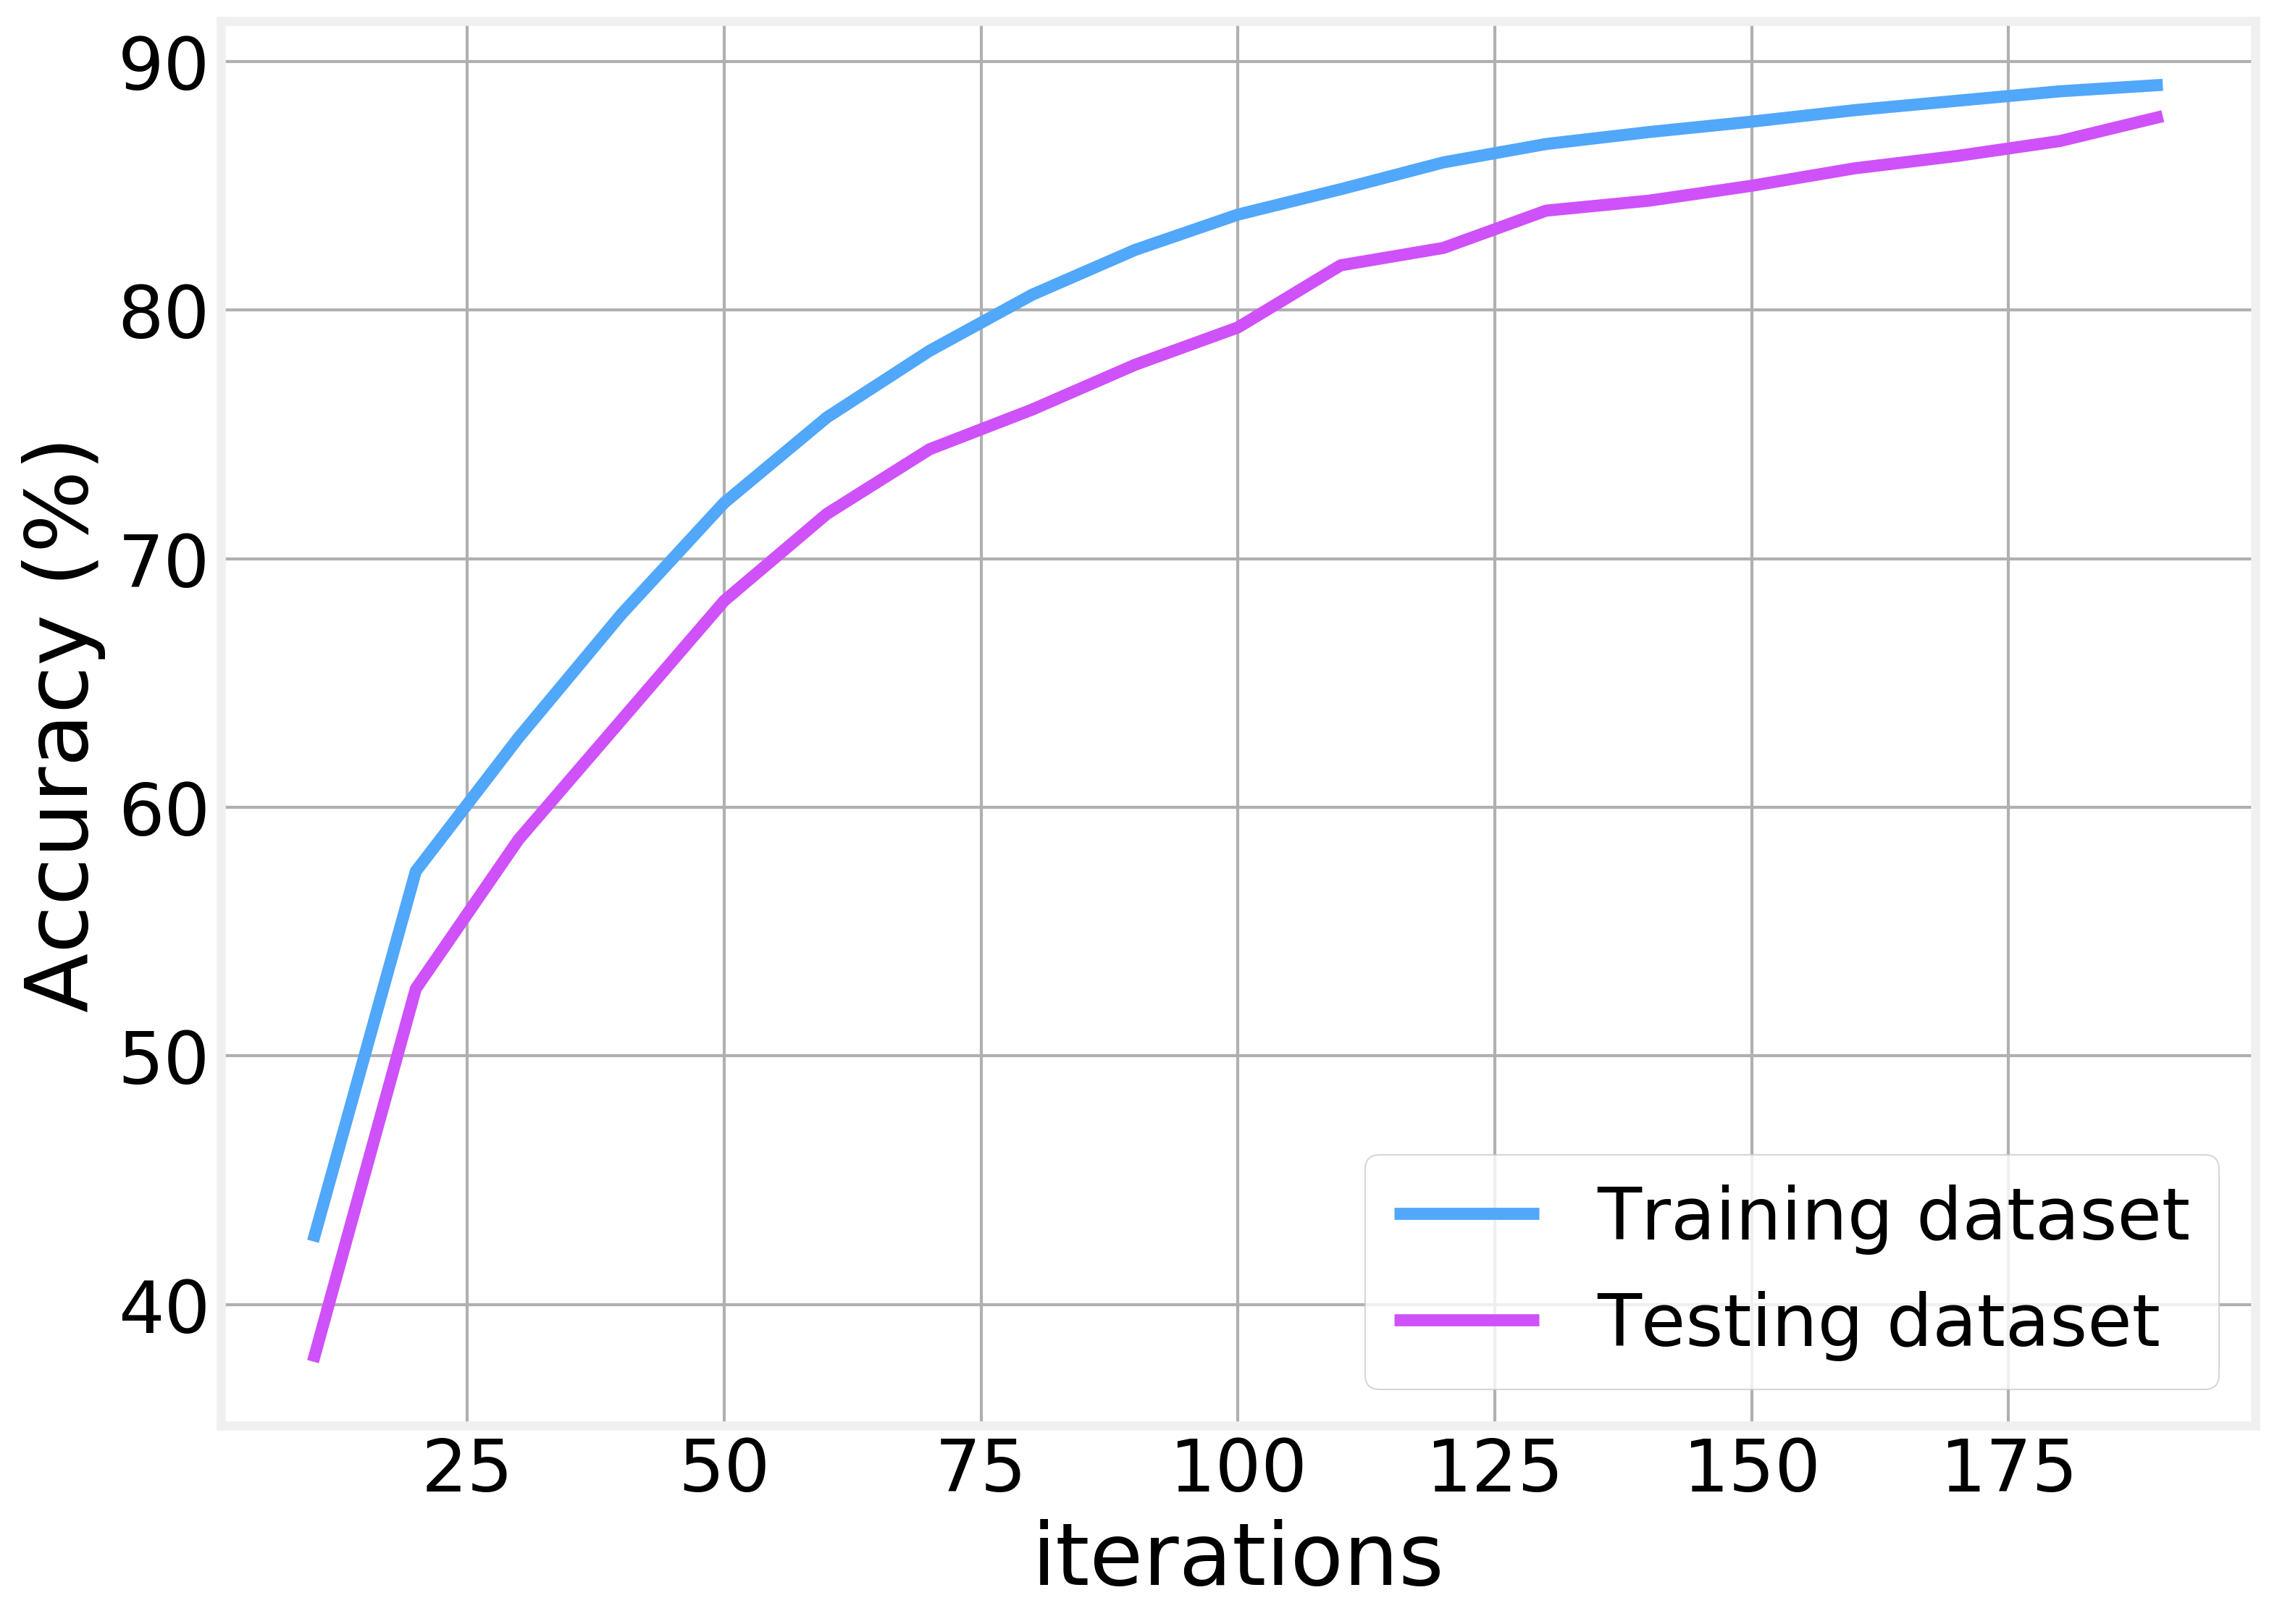

In [19]:
plt.plot(steps, acc_train, label='Training dataset')
plt.plot(steps, acc_test, label='Testing dataset')
plt.xlabel("iterations")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.gcf().set_size_inches(11, 8)

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>